In [1]:
####################################################################################
# Notebook to be used for training and testing an MLP model using FASTAI/Pytorch   # 
####################################################################################

In [2]:
# Need to add the FASTAI install to Dockerfile 
# ! pip3 install fastai==1.0.61

In [3]:
# Import libraries
from fastai.tabular import *
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os
import sys
import glob
from sklearn.utils import shuffle

In [4]:
dep_var = 'label'
cat_names = ['dst_port', 'protocol']

cont_names = ['timestamp', 'flow_duration', 'tot_fwd_pkts', 
              'tot_bwd_pkts', 'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max', 
              'fwd_pkt_len_min', 'fwd_pkt_len_mean', 'fwd_pkt_len_std', 
              'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_mean', 
              'bwd_pkt_len_std', 'flow_byts_s', 'flow_pkts_s', 'flow_iat_mean', 
              'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot', 
              'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min', 
              'bwd_iat_tot', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max',
              'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags', 
              'bwd_urg_flags', 'fwd_header_len', 'bwd_header_len', 'fwd_pkts_s',
              'bwd_pkts_s', 'pkt_len_min', 'pkt_len_max', 'pkt_len_mean', 
              'pkt_len_std', 'pkt_len_var', 'fin_flag_cnt', 'syn_flag_cnt',
              'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt',
              'cwe_flag_count', 'ece_flag_cnt', 'down_up_ratio', 'pkt_size_avg',
              'fwd_seg_size_avg', 'bwd_seg_size_avg', 'fwd_byts_b_avg',
              'fwd_pkts_b_avg', 'fwd_blk_rate_avg', 'bwd_byts_b_avg', 
              'bwd_pkts_b_avg', 'bwd_blk_rate_avg', 'subflow_fwd_pkts', 
              'subflow_fwd_byts', 'subflow_bwd_pkts', 'subflow_bwd_byts', 
              'init_fwd_win_byts', 'init_bwd_win_byts', 'fwd_act_data_pkts',
              'fwd_seg_size_min', 'active_mean', 'active_std', 'active_max',
              'active_min', 'idle_mean', 'idle_std', 'idle_max', 'idle_min']

In [5]:
rawdata_path = './data'
processed_path = os.path.join(rawdata_path, 'processed')
results_path = './results'

In [6]:
def loadDataFile(fileName):
    global processed_path
    dataFile = os.path.join(processed_path, fileName)
    pickleDump = '{}.pickle'.format(dataFile)
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
    else:
        df = pd.read_csv(dataFile)
        df = df.dropna()
        df = shuffle(df)
        df.to_pickle(pickleDump)
    return df

In [7]:
def modelIndividual(dataFile, epochs=5, normalize=False):
    global processed_path
    global results_path
    
    # Create folder for processed files if none exists
    if not os.path.exists(results_path):
        os.mkdir(results_path)    
    
    # procs = [FillMissing, Categorify, Normalize]
    procs = [FillMissing, Categorify]
    if normalize:
        procs.append(Normalize)

    seed = 7
    np.random.seed(seed)
    # load data
    data = loadDataFile(dataFile)
    # define 10-fold cross validation test harness
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    cvscores = []
    fold = 1
    for train_idx, test_idx in kfold.split(data.index, data[dep_var]):
        print('running fold = ', fold)
        fold += 1
        # create model
        data_fold = (TabularList.from_df(data, path=processed_path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                     .split_by_idxs(train_idx, test_idx)
                     .label_from_df(cols=dep_var)
                     .databunch())
        # create model and learn
        model = tabular_learner(
            data_fold, layers=[200, 100], metrics=accuracy, callback_fns=ShowGraph)
        model.fit(epochs, 1e-2)
        model.save('{}.model'.format(os.path.basename(dataFile)))
        # train the model, iterating on the data in batches of batch_size
        # evaluate the model
        loss, acc = model.validate()
        print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))
        cvscores.append(acc*100)
        resultFile = os.path.join(results_path, dataFile)
        with open('{}.result'.format(resultFile), 'a') as fout:
            fout.write(
                'accuracy: {:.2f} std-dev: {:.2f}\n'.format(np.mean(cvscores), np.std(cvscores)))

running fold =  1


epoch,train_loss,valid_loss,accuracy,time
0,0.212715,117.128151,0.889158,01:11
1,0.205006,229.097366,0.864165,01:07
2,0.181729,74.325691,0.841122,01:07
3,0.168782,25.966249,0.848352,01:08
4,0.151549,27.155172,0.893735,01:07


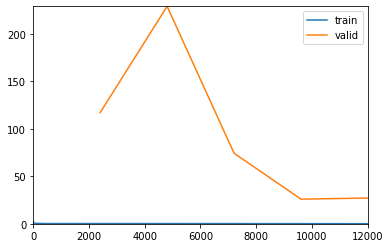

loss 27.15517234802246: accuracy: 89.37%
running fold =  2


epoch,train_loss,valid_loss,accuracy,time
0,0.218029,173.861572,0.899222,01:06
1,0.181688,52.729332,0.902655,01:07
2,0.180876,4890.038574,0.853762,01:07
3,0.167836,58.775215,0.867780,01:06
4,0.152602,9.062429,0.902707,01:06


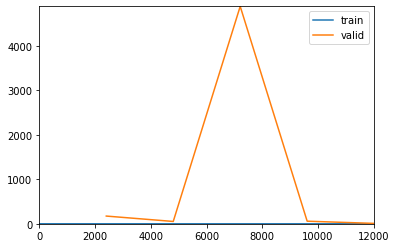

loss 9.062429428100586: accuracy: 90.27%
running fold =  3


epoch,train_loss,valid_loss,accuracy,time
0,0.215696,94.952599,0.886791,01:06
1,0.179148,966.887207,0.856753,01:06
2,0.164901,1.887090,0.850303,01:07
3,0.175641,331.498749,0.892825,01:06
4,0.142660,0.877149,0.848508,01:06


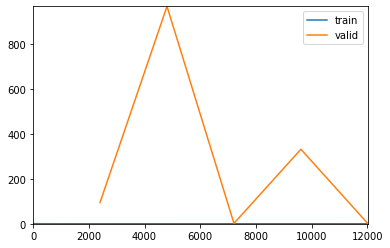

loss 0.8771494626998901: accuracy: 84.85%
running fold =  4


epoch,train_loss,valid_loss,accuracy,time
0,0.203677,42.693756,0.850901,01:07
1,0.208265,82.169762,0.789732,01:06
2,0.166830,13.165901,0.902135,01:07
3,0.163664,70.806282,0.897662,01:06
4,0.169005,1.063565,0.874802,01:07


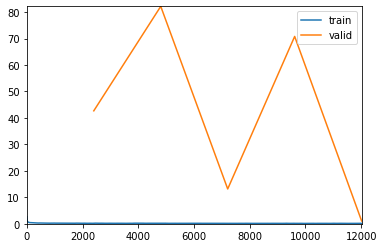

loss 1.0635648965835571: accuracy: 87.48%
running fold =  5


epoch,train_loss,valid_loss,accuracy,time
0,0.212937,5.263823,0.879688,01:07
1,0.183462,9.473620,0.900884,01:08
2,0.158924,30.835276,0.903849,01:06
3,0.161706,11.988036,0.904473,01:07
4,0.165638,0.238497,0.857217,01:07


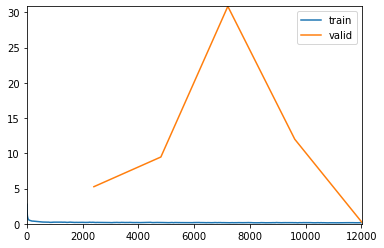

loss 0.2384968250989914: accuracy: 85.72%


In [8]:
 modelIndividual('IDS-2018-multiclass.csv')